THIS NOTEBOOK IS TO FIND IF PHYSICAL ATTRIBUTES OF A MALE SWIMMER HAS ANY EFFECT ON THIER CHANCE OF MEDAL WIN.

In [1]:
!pip install imblearn
!pip install xgboost
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import sklearn.ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import TimeSeriesSplit
from imblearn.combine import SMOTETomek
from sklearn import metrics
import imblearn
import collections
from imblearn.over_sampling import SMOTE
from sklearn.metrics import brier_score_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.tree import DecisionTreeClassifier
import time
import xgboost
from xgboost import XGBClassifier
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy import stats

MERGING THE EVENTS AND REGIONS DATASET

In [2]:
events=pd.read_csv("/home/jovyan/athlete_events.csv") 
regions=pd.read_csv("/home/jovyan/noc_regions.csv")
olympics = pd.merge(events, regions, on="NOC", how="left") 
print(olympics.head(),olympics.shape)

   ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal       region notes  
0       Basketball Men's Basketball   NaN        China   NaN  
1      Judo Men's Extra-Lightwei

Filtering to only contain rows that correspond to Summer Olympics and also excluding year 1906 Intercaleted Games from the data. IN this game medals were distributed but are no longer recognized by the International Olympic Committee.

In [3]:
Summer_olympics=olympics[(olympics.Season=='Summer') & (olympics.Year!=1906)]

In [4]:
Summer_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 220819 entries, 0 to 271110
Data columns (total 17 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      220819 non-null  int64  
 1   Name    220819 non-null  object 
 2   Sex     220819 non-null  object 
 3   Age     212373 non-null  float64
 4   Height  170438 non-null  float64
 5   Weight  168493 non-null  float64
 6   Team    220819 non-null  object 
 7   NOC     220819 non-null  object 
 8   Games   220819 non-null  object 
 9   Year    220819 non-null  int64  
 10  Season  220819 non-null  object 
 11  City    220819 non-null  object 
 12  Sport   220819 non-null  object 
 13  Event   220819 non-null  object 
 14  Medal   33630 non-null   object 
 15  region  220449 non-null  object 
 16  notes   4361 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 30.3+ MB


In [5]:
# Descriptive Statistics
Summer_olympics.describe()
Summer_olympics.iloc[:,1:].describe()

,Age,Height,Weight,Year
count,212373.000000,170438.000000,168493.000000,220819.000000
mean,25.667288,175.511494,70.682699,1976.868947
std,6.692954,10.918801,14.805977,30.427978
min,10.000000,127.000000,25.000000,1896.000000
25%,21.000000,168.000000,60.000000,1960.000000
50%,24.000000,175.000000,70.000000,1984.000000
75%,28.000000,183.000000,79.000000,2000.000000
max,97.000000,226.000000,214.000000,2016.000000


In [6]:
#lets filter only the w=swimming data:
Swimming_olympics = Summer_olympics[Summer_olympics.Sport=='Swimming']
Swimming_olympics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23117 entries, 29 to 271088
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      23117 non-null  int64  
 1   Name    23117 non-null  object 
 2   Sex     23117 non-null  object 
 3   Age     22614 non-null  float64
 4   Height  19134 non-null  float64
 5   Weight  18790 non-null  float64
 6   Team    23117 non-null  object 
 7   NOC     23117 non-null  object 
 8   Games   23117 non-null  object 
 9   Year    23117 non-null  int64  
 10  Season  23117 non-null  object 
 11  City    23117 non-null  object 
 12  Sport   23117 non-null  object 
 13  Event   23117 non-null  object 
 14  Medal   3027 non-null   object 
 15  region  22970 non-null  object 
 16  notes   515 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 3.2+ MB


In [7]:
Swimming_olympics['Medal'].value_counts()

Gold      1092
Silver     986
Bronze     949
Name: Medal, dtype: int64

#lets create separate columns for gold,silver and bronnze using get_dummies method and add new column 'all medals', to represnt if any medal is won or not

In [8]:
Swimming_olympics["Medal"].fillna("None",inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [9]:
swim_Male= Swimming_olympics[Swimming_olympics.Sex=='M']
swim_Female= Swimming_olympics[Swimming_olympics.Sex=='F']
swim_Male.info()
swim_Female.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13267 entries, 29 to 271088
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      13267 non-null  int64  
 1   Name    13267 non-null  object 
 2   Sex     13267 non-null  object 
 3   Age     12853 non-null  float64
 4   Height  10562 non-null  float64
 5   Weight  10327 non-null  float64
 6   Team    13267 non-null  object 
 7   NOC     13267 non-null  object 
 8   Games   13267 non-null  object 
 9   Year    13267 non-null  int64  
 10  Season  13267 non-null  object 
 11  City    13267 non-null  object 
 12  Sport   13267 non-null  object 
 13  Event   13267 non-null  object 
 14  Medal   13267 non-null  object 
 15  region  13172 non-null  object 
 16  notes   364 non-null    object 
dtypes: float64(3), int64(2), object(12)
memory usage: 1.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9850 entries, 474 to 270943
Data columns (total 17 columns):
 #   Column 

Lets find theCorrelations between input variables Age,height,weight and Output variable Medal

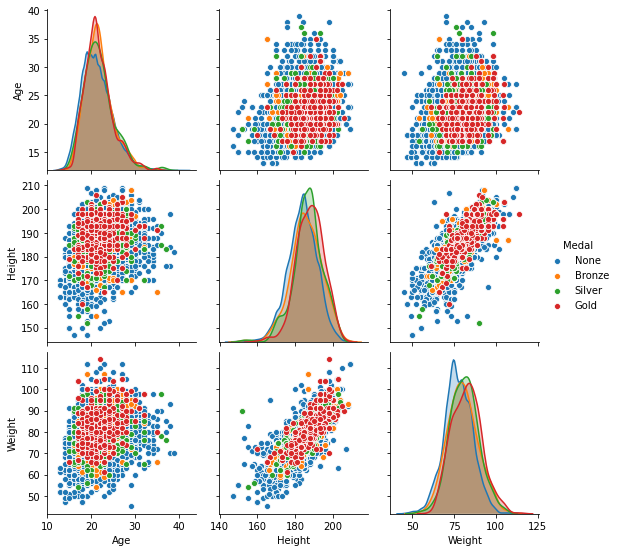

In [10]:
sns.pairplot(swim_Male[["Age", "Height", "Weight", "Medal"]], hue="Medal")

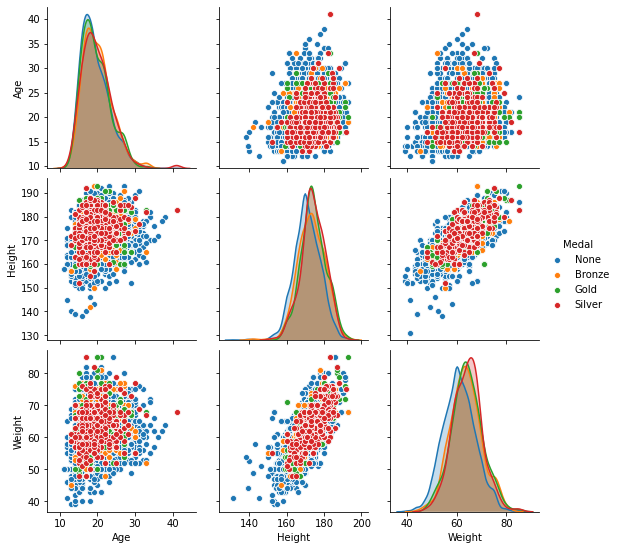

In [11]:
sns.pairplot(swim_Female[["Age", "Height", "Weight", "Medal"]], hue="Medal")

OBSERVATION: Scatter plots are less dispersed across the x-axis for medal winners vs for those who didn’t win medals, that’s an indication that a correlation between the inputs and output exists and are an important predictor of swimming performance.

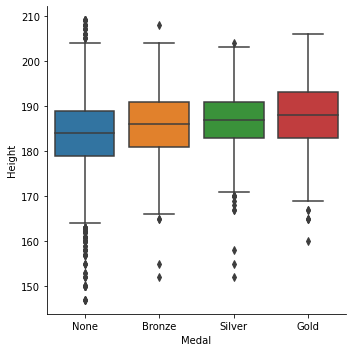

In [12]:
sns.catplot(x="Medal", y="Height", kind="box", data=swim_Male);

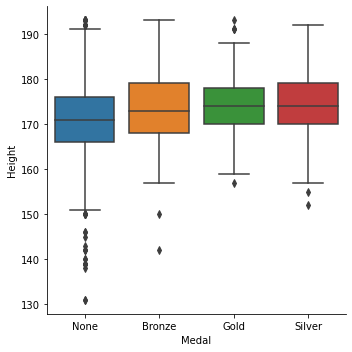

In [13]:
sns.catplot(x="Medal", y="Height", kind="box", data=swim_Female);

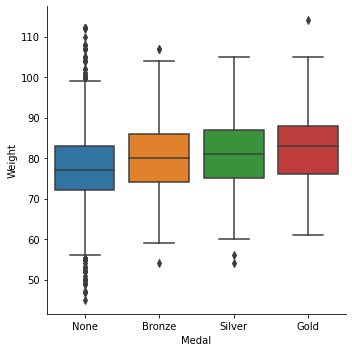

In [14]:
sns.catplot(x="Medal", y="Weight", kind="box", data=swim_Male);

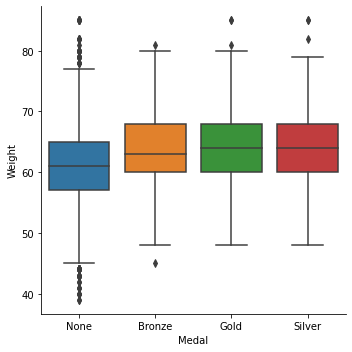

In [15]:
sns.catplot(x="Medal", y="Weight", kind="box", data=swim_Female);

BOX PLOT ANALYSIS: Do observe that as the median height increases the probability of winning a gold medal also kind of increases for Male and Female. The optimal median height appears to be 187 cm for males and 173 cm for females.
The optimal median weight appears to be 80 Kg for males and 63 Kg for females.

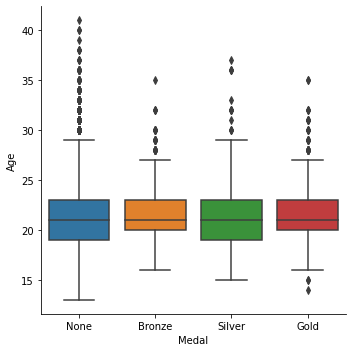

In [16]:
sns.catplot(x="Medal", y="Age", kind="box", data=swim_Male);

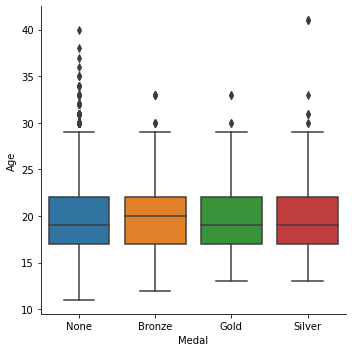

In [17]:
sns.catplot(x="Medal", y="Age", kind="box", data=swim_Female);

Above figures show that regardless of medals won, most male swimmers reach their peak performance at 22 years old and women at around 19 years old.

In [18]:
swim_Male = pd.concat([swim_Male,pd.get_dummies(swim_Male.Medal)],axis=1)
swim_Male['allmedals']= swim_Male['Bronze']+swim_Male['Gold']+swim_Male['Silver']
swim_Male.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13267 entries, 29 to 271088
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         13267 non-null  int64  
 1   Name       13267 non-null  object 
 2   Sex        13267 non-null  object 
 3   Age        12853 non-null  float64
 4   Height     10562 non-null  float64
 5   Weight     10327 non-null  float64
 6   Team       13267 non-null  object 
 7   NOC        13267 non-null  object 
 8   Games      13267 non-null  object 
 9   Year       13267 non-null  int64  
 10  Season     13267 non-null  object 
 11  City       13267 non-null  object 
 12  Sport      13267 non-null  object 
 13  Event      13267 non-null  object 
 14  Medal      13267 non-null  object 
 15  region     13172 non-null  object 
 16  notes      364 non-null    object 
 17  Bronze     13267 non-null  uint8  
 18  Gold       13267 non-null  uint8  
 19  None       13267 non-null  uint8  
 20  Silv

NOW Lets Predict if physical Attributes of Male Swimmers like Age, Height and Weight has any effect on their Medal Wins.

In [19]:
## Data Split into Train and Test
data_test = swim_Male[swim_Male.Year>=2008]
data_train = swim_Male[swim_Male.Year<2008]

#dropping columns ID, Games and notes
data_train = data_train.drop(data_train.columns[[0,8, 16]], axis=1)
data_test = data_test.drop(data_test.columns[[0,8, 16]], axis=1)

data_test.info()
data_train.info()
print("test data percentage: %.3f%%" % (round(2489/13267 * 100.0)))
print("train data percentage: %.3f%%" % (round(10778/13267 * 100.0)))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 258 to 270559
Data columns (total 19 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Name       2489 non-null   object 
 1   Sex        2489 non-null   object 
 2   Age        2489 non-null   float64
 3   Height     2442 non-null   float64
 4   Weight     2439 non-null   float64
 5   Team       2489 non-null   object 
 6   NOC        2489 non-null   object 
 7   Year       2489 non-null   int64  
 8   Season     2489 non-null   object 
 9   City       2489 non-null   object 
 10  Sport      2489 non-null   object 
 11  Event      2489 non-null   object 
 12  Medal      2489 non-null   object 
 13  region     2477 non-null   object 
 14  Bronze     2489 non-null   uint8  
 15  Gold       2489 non-null   uint8  
 16  None       2489 non-null   uint8  
 17  Silver     2489 non-null   uint8  
 18  allmedals  2489 non-null   uint8  
dtypes: float64(3), int64(1), object(10), uint8(5

DATA IMPUTATION: During EXPLORATION, we observed genuine outliers for Varibales AGE,HEIGHT AND WEIGHT which cannot be replaced with mean or deleted as it might then defeat the whole purpose of using data of Olympians. so Imputation is done using median.

In [20]:
## filling the NaN values of column 'Region' by taking the values from 'Team' 
data_train["region"].fillna(data_train["Team"], inplace=True)

## imputing the Age,Height,weight using the median
import numpy as np
imp_col = ['Age','Height','Weight']
for col in imp_col:
    data_train[col] = data_train[col].fillna((data_train[col].median()))

In [21]:
print(data_train.isnull().sum())

Name         0
Sex          0
Age          0
Height       0
Weight       0
Team         0
NOC          0
Year         0
Season       0
City         0
Sport        0
Event        0
Medal        0
region       0
Bronze       0
Gold         0
None         0
Silver       0
allmedals    0
dtype: int64


In [22]:
#Sorting the data by Year
data_train = data_train.sort_values(by = ["Year", "NOC"])

Lets check if the data sample is mormally distributrd or not.

In [23]:
#Shapiro-Wilk Test
stat,p = shapiro(data_train[["Weight","Height"]])
print('Statistics=%.3f, p=%.3f' % (stat,p))


#Kolmogorov-Smirnov test 
print(stats.kstest(data_train[["Height"]], 'norm'))
print(stats.kstest(data_train[["Weight"]], 'norm'))

###OBSERVATION: DATA DISTRIBUTION IS NOT NORMAL

Statistics=0.747, p=0.000


/opt/conda/lib/python3.7/site-packages/scipy/stats/morestats.py:1676: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


KstestResult(statistic=1.0, pvalue=0.0)
KstestResult(statistic=1.0, pvalue=0.0)


# Lets Predict if physical Attributes of Male Swimmers like Height and Weight has any effect on Medal Wins. 

In [24]:
X_train=data_train.loc[:,["Age","Height","Weight","Year"]]
Y_train=data_train['allmedals']

In [25]:
Y_train.value_counts()

0    9418
1    1360
Name: allmedals, dtype: int64

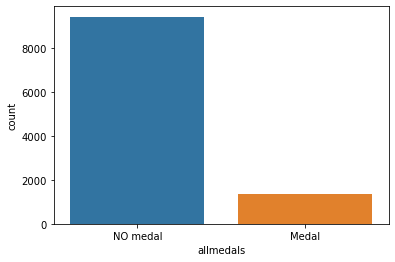

In [26]:
# visualize the target variable
g = sns.countplot(Y_train)
g.set_xticklabels(['NO medal','Medal'])
plt.show()

Observation: IMBALANCED DATASET

FEATURE SELECTION: JUST TO ENSURE ALL THE THREE VARIABLES ARE OF IMPORTANCE.
The SMOTE paper describes that the feature selection should be performed before sampling. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3648438/)

In [27]:
##Feature Selection: RandomForest Classifier
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=30))
embeded_rf_selector.fit(X_train[['Age','Height','Weight']],Y_train)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train[['Age','Height', 'Weight']].loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')
print(embeded_rf_feature)

2 selected features
['Height', 'Weight']


Feature: 0, Score: 0.29808
Feature: 1, Score: 0.32012
Feature: 2, Score: 0.38180


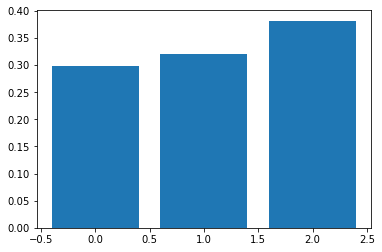

In [28]:
# decision tree for feature importance on a classification problem

from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot


# define the model
model = DecisionTreeClassifier()
# fit the model
model.fit(X_train[['Age','Height', 'Weight']],Y_train)
# get importance
importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [29]:
##Feature Selection: Recursive Feature Elimination
#X_norm = MinMaxScaler().fit_transform(X_train[['Age','Height', 'Weight','Sex']])
rfe_selector = RFE(estimator=XGBClassifier(),n_features_to_select=2, step=10, verbose=5)
rfe_selector.fit(X_train[['Age','Height', 'Weight']], Y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train[['Age','Height', 'Weight']].loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 3 features.
[18:37:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:37:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
2 selected features
['Height', 'Weight']


[18:37:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


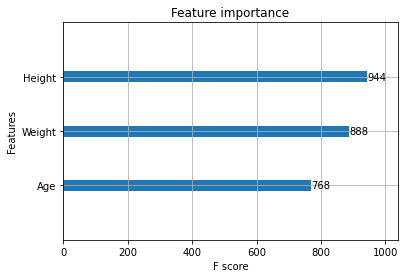

In [30]:
from xgboost import plot_importance
model = XGBClassifier()
model.fit(X_train[['Age','Height', 'Weight']], Y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

Lets Balance the Dataset using the Hybrid technique - SMOTE + TOMEK Links (Oversampling and undersampling techniques)

In [31]:
#Hybridization: SMOTE + TOMEK Links (Oversampling and undersampling techniques)
from imblearn.combine import SMOTETomek
smtom = SMOTETomek(random_state = 139)
X_train_smtom, Y_train_smtom = smtom.fit_resample(X_train,Y_train)
print('Original dataset shape', collections.Counter(Y_train))
print('Resample dataset shape', collections.Counter(Y_train_smtom))

Original dataset shape Counter({0: 9418, 1: 1360})
Resample dataset shape Counter({1: 9367, 0: 9367})


In [32]:
X_train_smtom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18734 entries, 0 to 18733
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     18734 non-null  float64
 1   Height  18734 non-null  float64
 2   Weight  18734 non-null  float64
 3   Year    18734 non-null  int64  
dtypes: float64(3), int64(1)
memory usage: 585.6 KB


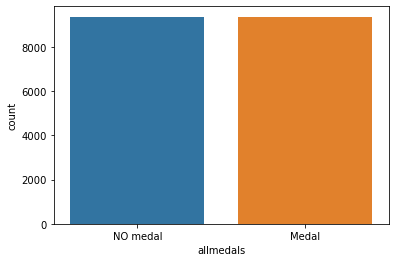

In [33]:
# visualize the target variable after SMOTETomek
g = sns.countplot(Y_train_smtom)
g.set_xticklabels(['NO medal','Medal'])
plt.show()

LETS PREPARE THE TEST DATA AS WELL. 
1)creating the column 'allmedals' using get_dummies method
2) filtering only the swimdata for Males
3) droping any na values


In [34]:
# # Preparing the Test data for prediction :


# creating a new data frame with the required features.
swim_test = data_test[["Height","Weight","allmedals","Age","Year"]]
swim_test.info()

#droping the NA values
swim_test= swim_test.dropna()
swim_test.info()

# creating the predictors and Target 
X_test = swim_test.loc[:,["Height","Weight","Year","Age"]]
Y_test = swim_test['allmedals']
print (X_test,Y_test)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 258 to 270559
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Height     2442 non-null   float64
 1   Weight     2439 non-null   float64
 2   allmedals  2489 non-null   uint8  
 3   Age        2489 non-null   float64
 4   Year       2489 non-null   int64  
dtypes: float64(3), int64(1), uint8(1)
memory usage: 99.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2437 entries, 258 to 270559
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Height     2437 non-null   float64
 1   Weight     2437 non-null   float64
 2   allmedals  2437 non-null   uint8  
 3   Age        2437 non-null   float64
 4   Year       2437 non-null   int64  
dtypes: float64(3), int64(1), uint8(1)
memory usage: 97.6 KB
        Height  Weight  Year   Age
258      182.0    76.0  2008  18.0
751      180.0    74.0  2016

# Building the Model
1)DecisionTree Classifier

In [35]:

dtree = DecisionTreeClassifier()
dtree.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)
print(dtree)
from pprint import pprint
# Look at parameters used by our current classifier
print('Parameters currently in use:\n')
pprint(dtree.get_params())

start = time.time()
# evaluate on the train dataset
DT_train = dtree.predict(X_train_smtom[['Height', 'Weight']])
train_acc = accuracy_score(Y_train_smtom, DT_train)
print("Accuracy_train: %.2f%%" % (train_acc * 100.0))

# evaluate on the test dataset

dtree.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom) 
DT_pred = dtree.predict(X_test[['Height', 'Weight']]) 
pred_acc = accuracy_score(Y_test, DT_pred)
print("Accuracy_pred: %.2f%%" % (pred_acc * 100.0))
end = time.time()
print(end - start, "seconds")
DT_time = end - start

DecisionTreeClassifier()
Parameters currently in use:

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}
Accuracy_train: 80.76%
Accuracy_pred: 79.93%
0.045907020568847656 seconds


In [36]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,DT_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, DT_pred))
print('\n')
print("=== All Train AUC Scores ===")
print(metrics.accuracy_score(Y_train_smtom, DT_train)*100)
print('\n')
print("=== All Test AUC Scores ===")
print(metrics.accuracy_score(Y_test, DT_pred)*100)
print('\n')
print("=== ROC AUC Scores ===")
print(metrics.roc_auc_score(Y_test, DT_pred))


=== Confusion Matrix ===
[[1871  274]
 [ 215   77]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2145
           1       0.22      0.26      0.24       292

    accuracy                           0.80      2437
   macro avg       0.56      0.57      0.56      2437
weighted avg       0.82      0.80      0.81      2437



=== All Train AUC Scores ===
80.75691256538913


=== All Test AUC Scores ===
79.93434550677063


=== ROC AUC Scores ===
0.5679798511990294


In [37]:
probs1 = dtree.predict_proba(X_test[['Height', 'Weight']])
# keep the predictions for class 1 only
probs1 = probs1[:, 1]
#Calculating the Brier Score loss
brier_score_loss(Y_test, probs1)

0.17268068976203693

2)RandomForest Classifier

In [38]:
RFtree = RandomForestClassifier()
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(RFtree.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Lets check the optimal value for max_depth

With Default Values

In [39]:
RFtree = RandomForestClassifier()
RFtree.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)

start = time.time()
# evaluate on the train dataset
train_RF = RFtree.predict(X_train_smtom[['Height', 'Weight']])
train_acc_RF = accuracy_score(Y_train_smtom, train_RF)*100
train_acc_RF

# evaluate on the test dataset
RF_pred = RFtree.predict(X_test[['Height', 'Weight']]) 
test_acc_RF = accuracy_score(Y_test, RF_pred)*100
print('train_acc:',train_acc_RF,'test_acc:',test_acc_RF)
end = time.time()
print(end - start, "seconds")
RF_time = end - start

train_acc: 80.75691256538913 test_acc: 80.22158391464916
0.30780482292175293 seconds


In [40]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,RF_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, RF_pred))
print('\n')
print("=== All Train AUC Scores ===")
print(metrics.accuracy_score(Y_train_smtom, train_RF)*100)
print('\n')
print("=== All Test AUC Scores ===")
print(metrics.accuracy_score(Y_test, RF_pred)*100)
print('\n')
print("=== ROC AUC Scores ===")
print(metrics.roc_auc_score(Y_test, RF_pred))


=== Confusion Matrix ===
[[1871  274]
 [ 208   84]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2145
           1       0.23      0.29      0.26       292

    accuracy                           0.80      2437
   macro avg       0.57      0.58      0.57      2437
weighted avg       0.82      0.80      0.81      2437



=== All Train AUC Scores ===
80.75691256538913


=== All Test AUC Scores ===
80.22158391464916


=== ROC AUC Scores ===
0.5799661525688924


In [41]:
probs1 = RFtree.predict_proba(X_test[['Height', 'Weight']])
# keep the predictions for class 1 only
probs1 = probs1[:, 1]
#Calculating the Brier Score loss
brier_score_loss(Y_test, probs1)

0.15840939368006676

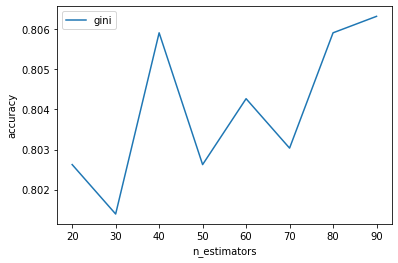

In [42]:
n_estimators = []
acc_gini = []
for i in range(20,100,10):
 RFtree = RandomForestClassifier(criterion='gini', n_estimators=i)
 RFtree.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)
 pred1 = RFtree.predict(X_test[['Height', 'Weight']])
 acc_gini.append(accuracy_score(Y_test, pred1))
 ####
 
 ####
 n_estimators.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
 'n_estimators':pd.Series(n_estimators)})
# visualizing changes in parameters
plt.plot('n_estimators','acc_gini', data=d, label='gini')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()

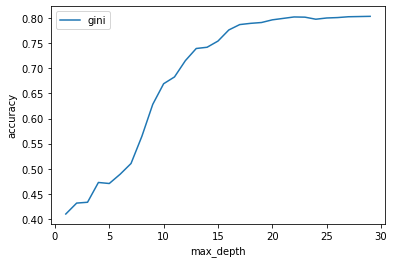

In [43]:
##Checking optimal number of max_depth to be used
max_depth = []
acc_gini = []
for i in range(1,30):
 RFtree= RandomForestClassifier(criterion='gini', max_depth=i)
 RFtree.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)
 pred = RFtree.predict(X_test[['Height', 'Weight']])
 acc_gini.append(accuracy_score(Y_test, pred))
 ####
 
 ####
 max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

In [44]:

RFtree1 = RandomForestClassifier(n_estimators=30,max_depth =18, random_state = 42)
RFtree1.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom) 

start = time.time()
# evaluate on the train dataset
train_RF = RFtree1.predict(X_train_smtom[['Height', 'Weight']])
train_acc_RF = accuracy_score(Y_train_smtom, train_RF)*100
train_acc_RF

# evaluate on the test dataset
pred1 = RFtree1.predict(X_test[['Height', 'Weight']]) 
test_acc_RF = accuracy_score(Y_test, pred1)*100
print('train_acc:',train_acc_RF,'test_acc:',test_acc_RF)
end = time.time()
print(end - start, "seconds")
RF_time = end - start

train_acc: 80.67684424041849 test_acc: 78.82642593352483
0.0985269546508789 seconds


In [45]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test,pred1))

=== Confusion Matrix ===
[[1830  315]
 [ 201   91]]


In [46]:
probs1 = RFtree1.predict_proba(X_test[['Height', 'Weight']])
# keep the predictions for class 1 only
probs1 = probs1[:, 1]
#Calculating the Brier Score loss
brier_score_loss(Y_test, probs1)

0.16090875294675078

3)XGBoost Claasifier

In [47]:

model = XGBClassifier()
# fit model on training data
model.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)

start = time.time()
#evaluating on training data
XG_train = model.predict(X_train_smtom[['Height', 'Weight']])
train_accuracy = accuracy_score(Y_train_smtom, XG_train)
print("Accuracy_train: %.2f%%" % (train_accuracy * 100.0))

#evaluating on test data
XG_pred = model.predict(X_test[['Height', 'Weight']])
pred_accuracy = accuracy_score(Y_test, XG_pred)
print("Accuracy_pred: %.2f%%" % (pred_accuracy * 100.0))
end = time.time()
print(end - start, "seconds")
XGB_time = end - start


[18:38:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Accuracy_train: 80.52%
Accuracy_pred: 82.03%
0.02141594886779785 seconds


In [48]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, XG_pred))


=== Confusion Matrix ===
[[1920  225]
 [ 213   79]]


[18:38:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:38:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

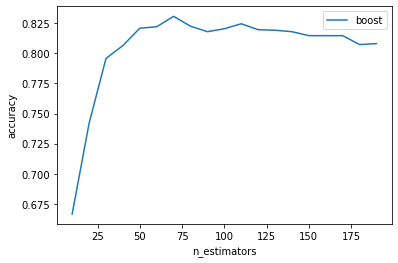

In [49]:
##Checking optimal number of estimators to be used
n_estimators = []
acc_boost = []
for i in range(10,200,10):
 XGB = XGBClassifier(n_estimators=i,use_label_encoder=False)
 XGB.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)
 pred3 = XGB.predict(X_test[['Height', 'Weight']])
 acc_boost.append(accuracy_score(Y_test, pred3))
 ####
 
 ####
 n_estimators.append(i)
d = pd.DataFrame({'acc_boost':pd.Series(acc_boost),
 'n_estimators':pd.Series(n_estimators)})
# visualizing changes in parameters
plt.plot('n_estimators','acc_boost', data=d, label='boost')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()

In [50]:

model1 = XGBClassifier( gamma=1,learning_rate =0.3,n_estimators=25)
# fit model on training data
model1.fit(X_train_smtom[['Height', 'Weight']],Y_train_smtom)
#print(model)
start = time.time()
#evaluating on training data
XG_train_new = model1.predict(X_train_smtom[['Height', 'Weight']])
train_accuracy = accuracy_score(Y_train_smtom, XG_train_new)
print("Accuracy_train: %.2f%%" % (train_accuracy * 100.0))

#evaluating on test data
XG_pred_new = model1.predict(X_test[['Height', 'Weight']])
pred_accuracy = accuracy_score(Y_test, XG_pred_new)
print("Accuracy_pred: %.2f%%" % (pred_accuracy * 100.0))
end = time.time()
print(end - start, "seconds")
XGB_time = end - start


[18:38:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy_train: 78.62%
Accuracy_pred: 77.47%
0.015169143676757812 seconds


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [51]:
print("=== Confusion Matrix ===")
print(confusion_matrix(Y_test, XG_pred_new))
print('\n')
print("=== Classification Report ===")
print(classification_report(Y_test, XG_pred_new))
print('\n')
print("=== All Train AUC Scores ===")
print(metrics.accuracy_score(Y_train_smtom, XG_train_new)*100)
print('\n')
print("=== All Test AUC Scores ===")
print(metrics.accuracy_score(Y_test, XG_pred_new)*100)
print('\n')
print("=== ROC AUC Scores ===")
print(metrics.roc_auc_score(Y_test, XG_pred_new)*100)

=== Confusion Matrix ===
[[1787  358]
 [ 191  101]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2145
           1       0.22      0.35      0.27       292

    accuracy                           0.77      2437
   macro avg       0.56      0.59      0.57      2437
weighted avg       0.82      0.77      0.80      2437



=== All Train AUC Scores ===
78.61641934450732


=== All Test AUC Scores ===
77.47230201066886


=== ROC AUC Scores ===
58.94953220295685


In [52]:
print("=== DT Classification Report ===")
print(classification_report(Y_test, DT_pred))
print('\n')
print("=== RF Classification Report ===")
print(classification_report(Y_test, pred1))
print('\n')
print("=== XGboost Classification Report ===")
print(classification_report(Y_test, XG_pred_new))

=== DT Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2145
           1       0.22      0.26      0.24       292

    accuracy                           0.80      2437
   macro avg       0.56      0.57      0.56      2437
weighted avg       0.82      0.80      0.81      2437



=== RF Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.85      0.88      2145
           1       0.22      0.31      0.26       292

    accuracy                           0.79      2437
   macro avg       0.56      0.58      0.57      2437
weighted avg       0.82      0.79      0.80      2437



=== XGboost Classification Report ===
              precision    recall  f1-score   support

           0       0.90      0.83      0.87      2145
           1       0.22      0.35      0.27       292

    accuracy                           0.77      2437
   macro avg       0

In [53]:
CM = confusion_matrix(Y_test, DT_pred)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR1 = TP/(TP+FN)
# Specificity or true negative rate
TNR1 = TN/(TN+FP) 
# Precision or positive predictive value
PPV1 = TP/(TP+FP)
# Negative predictive value
NPV1 = TN/(TN+FN)
# Fall out or false positive rate
FPR1 = FP/(FP+TN)
# False negative rate
FNR1 = FN/(TP+FN)
# False discovery rate
FDR1 = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [54]:
print("=== DT (TN,FN,TP,FP)===")
print(TN,FN,TP,FP)
print(" DF Sensitivity rate: %0.2f" % (TPR1))
print(" DF Specificity rate: %0.2f" % (TNR1))

=== DT (TN,FN,TP,FP)===
1871 215 77 274
 DF Sensitivity rate: 0.26
 DF Specificity rate: 0.87


In [55]:
CM = confusion_matrix(Y_test, pred1)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR2 = TP/(TP+FN)
# Specificity or true negative rate
TNR2 = TN/(TN+FP) 
# Precision or positive predictive value
PPV2 = TP/(TP+FP)
# Negative predictive value
NPV2 = TN/(TN+FN)
# Fall out or false positive rate
FPR2 = FP/(FP+TN)
# False negative rate
FNR2 = FN/(TP+FN)
# False discovery rate
FDR2 = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [56]:
print("=== RF (TN,FN,TP,FP)===")
print(TN,FN,TP,FP)
print(" RF Sensitivity rate: %0.2f" % (TPR2))
print(" RF Specificity rate: %0.2f" % (TNR2))

=== RF (TN,FN,TP,FP)===
1830 201 91 315
 RF Sensitivity rate: 0.31
 RF Specificity rate: 0.85


In [57]:
CM1 = confusion_matrix(Y_test, XG_pred_new)
TN = CM1[0][0]
FN = CM1[1][0]
TP = CM1[1][1]
FP = CM1[0][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR3 = TP/(TP+FN)
# Specificity or true negative rate
TNR3 = TN/(TN+FP) 
# Precision or positive predictive value
PPV3 = TP/(TP+FP)
# Negative predictive value
NPV3 = TN/(TN+FN)
# Fall out or false positive rate
FPR3 = FP/(FP+TN)
# False negative rate
FNR3 = FN/(TP+FN)
# False discovery rate
FDR3 = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

In [58]:
print("=== XGBoost(TN,FN,TP,FP)===")
print(TN,FN,TP,FP)
print(" XG Sensitivity rate: %0.2f" % (TPR3))
print(" XG Specificity rate:%0.2f" % (TNR3))

=== XGBoost(TN,FN,TP,FP)===
1787 191 101 358
 XG Sensitivity rate: 0.35
 XG Specificity rate:0.83


In [59]:
print("=== F1Score_DT ===")
print(metrics.f1_score(Y_test, DT_pred))
print('\n')
print("=== F1Score_RandomForest ===")
print(metrics.f1_score(Y_test, pred1))
print('\n')
print("=== F1Score_XGBoost ===")     
print(metrics.f1_score(Y_test, XG_pred_new))

=== F1Score_DT ===
0.23950233281493002


=== F1Score_RandomForest ===
0.26074498567335247


=== F1Score_XGBoost ===
0.26897470039946736


In [60]:
#Brier Score
probs1 = RFtree.predict_proba(X_test[['Height', 'Weight']])
probs2 = model.predict_proba(X_test[['Height', 'Weight']])

# keep the predictions for class 1 only
probs1 = probs1[:, 1]
probs2 = probs2[:, 1]
#Calculating the Brier Score loss
print("brier_score_loss_RF: %0.2f" % brier_score_loss(Y_test, probs1))
print("brier_score_loss_XGB: %.2f" % brier_score_loss(Y_test, probs2))


brier_score_loss_RF: 0.16
brier_score_loss_XGB: 0.15


In [63]:
print( "Execution_time_DT: %0.2f" % DT_time)
print( "Execution_time_RF: %0.2f" % RF_time)
print( "Execution_time_XG: %0.2f" % XGB_time)

Execution_time_DT: 0.05
Execution_time_RF: 0.10
Execution_time_XG: 0.02


In [64]:
#calculating Matthews correlation coefficient
matthews_corrcoef(Y_test,DT_pred)
print( "MCC_DT: %0.2f" % matthews_corrcoef(Y_test,DT_pred))
print( "MCC_RF: %0.2f" % matthews_corrcoef(Y_test,pred1))
print( "MCC_XG: %0.2f" % matthews_corrcoef(Y_test,XG_pred_new))

MCC_DT: 0.13
MCC_RF: 0.14
MCC_XG: 0.15


In [66]:
data = [['DT', accuracy_score(Y_test, DT_pred),metrics.balanced_accuracy_score(Y_test, DT_pred),metrics.f1_score(Y_test, DT_pred),matthews_corrcoef(Y_test,  DT_pred),DT_time],['RF',metrics.accuracy_score(Y_test, pred1),metrics.balanced_accuracy_score(Y_test, pred1),metrics.f1_score(Y_test, pred1),matthews_corrcoef(Y_test,pred1),RF_time],['XGB',metrics.accuracy_score(Y_test, XG_pred_new),metrics.balanced_accuracy_score(Y_test, XG_pred_new),metrics.f1_score(Y_test,XG_pred_new),
matthews_corrcoef(Y_test,XG_pred_new),0.01]]
df = pd.DataFrame(data,columns = ['Models','Accuracy_score','Balanced_accuracy_score','F1_Score_class1','MCC','Execution_time'])
print(df)

  Models  Accuracy_score  Balanced_accuracy_score  F1_Score_class1       MCC  \
0     DT        0.799343                 0.567980         0.239502  0.125749   
1     RF        0.788264                 0.582395         0.260745  0.143622   
2    XGB        0.774723                 0.589495         0.268975  0.148667   

   Execution_time  
0        0.045907  
1        0.098527  
2        0.010000  


Summarizing the performace of all the three Models

In [67]:
from scipy.stats import friedmanchisquare
# compare samples
stat, p = friedmanchisquare(DT_pred, pred1, XG_pred_new)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

Statistics=63.399, p=0.000
Different distributions (reject H0)


 # CONCLUSION:Based on all the Evaluation Metrics, XGboost is found to be the most effective classifier to predict the chance of medal win given the swimmers Weight and height.